# Tracker Results
Full tracker results for test scenarios:
- Test 1
- Test 2
- Test 3
- Test 4

Four combinations of object detectors and object trackers are compared:
- OD1+OA1 (ssd_mobilenet_v2_coco + pixel_feature_matching)
- OD1+OA2 (ssd_mobilenet_v2_coco + complex_feature_matching)
- OD2+OA1 (faster_rcnn_resnet101_coco + pixel_feature_matching)
- OD2+OA2 (faster_rcnn_resnet101_coco + complex_feature_matching)

Tracker results are processed into outputs relevant to urban analytics such as crowding, dwell times and distances. Full contents:
1. Extract Results
2. Tracking Results
3. Plot Tracking Results
4. Calculate Pedestrian Attributes
5. Pedestrian Behaviours
6. Process Temporal Patterns
7. Plot Temporal Patterns
8. Visualise Trajectories
9. Visualise Flows

Results are compared to Ground Truth data to allow consideraion of tracker quality.

In [16]:
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import math
import tracker_helpers as tracker
from datetime import datetime

In [17]:
source = 'results'
verbose = False

## 1. Extract Results
Extract results from Tracker

In [18]:
# Loop through tests, loading results into lists of dictionaries
tests = ['test1', 'test2', 'test3', 'test4']
tests_short = ['Test 1', 'Test 2', 'Test 3', 'Test 4']

detection_models = ['ssd_mobilenet_v2_coco',
          'faster_rcnn_resnet101_coco']

detection_models_short = ['ssd_mobilenet_v2',
                          'f_rcnn_resnet101']

odms = ['OD1', 'OD2']

association_models = ['pixel_feature_matching', 'complex_feature_matching']

oams = ['OA1', 'OA2']

comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']

In [19]:
# extract GTs
gts = {}
for test in tests:
    gt_path = os.path.join('MOT', 'test', test, 'gt', 'gt.csv')
    with open(gt_path, 'r') as f:
      reader = csv.reader(f)
      gt_raw = list(reader)
    
    gt = []
    for result in gt_raw:
        if not int(result[1]) == -1:
            gt.append(result)
    gt_array = np.array(gt)

    gts[test] = gt_array.astype('float')

In [20]:
# extract all test results
tests_results = {}
tests_performances = {}
for test in tests:
    models_results = {}
    models_performances = {}
    for od, detection_model in zip(odms, detection_models):
        for oa, association_model in zip(oams, association_models):
            model_string = od + '+' + oa
            path = os.path.join(source, 'tracker_' + test + '_2018-08-10_' + detection_model + '__' + association_model)
            
            results_path = os.path.join(path, '2015-01-03.npy')
            results = np.load(results_path)
            models_results[model_string] = results
            
            performance_path = os.path.join(path, 'performance_2015-01-03.npy')
            performance = np.load(performance_path)
            models_performances[model_string] = performance
            
    tests_results[test] = models_results
    tests_performances[test] = models_performances
            

## 2. Tracking Results
Results and performance are calcualted for each detection and association pair for each test. Crowding and Dwelling error are calculated by comparison to the ground truthing.

In [21]:
# format results for table:
# test *
# od_oa vs [c, c%, d, d%,p]
tables = pd.DataFrame()
tests_scores = {}

for test in tests:
    models_results = tests_results.get(test)
    gt = gts.get(test)
    _gt_crowding, _gt_dwelling = tracker.get_track_results(gt, verbose=False)
    models_performances = tests_performances.get(test)
    
    gt_crowding = [_gt_crowding]*4
    models_crowding = []
    models_rel_crowding = []
    gt_dwelling = [_gt_dwelling]*4
    models_dwelling = []
    models_rel_dwelling = []
    models_perf = []
    
    models_scores = {}
    
    for od, detection_model in zip(odms, detection_models):
        for oa, association_model in zip(oams, association_models):
            model_string = od + '+' + oa
            results = models_results.get(model_string)
            crowding, dwelling = tracker.get_track_results(results)
            
            rel_crowding = (crowding - _gt_crowding) / _gt_crowding
            rel_dwelling = (dwelling - _gt_dwelling) / _gt_dwelling
                            
            performance = models_performances.get(model_string)[()].get('av_time')
            
            models_scores[model_string] = {'crowding_error': rel_crowding,
                                          'dwelling_error': rel_dwelling,
                                          'performance_seconds': performance}
            
            models_crowding.append(crowding)
            models_rel_crowding.append(rel_crowding)
            models_dwelling.append(dwelling)
            models_rel_dwelling.append(rel_dwelling)
            models_perf.append(performance)
            
    all_dict = {'test': [test] * 4,
                'models': comb,
                'actual_crowding': gt_crowding,
                'measured_crowding':models_crowding,
                'crowding_error': models_rel_crowding,
                'actual_dwelling':gt_dwelling,
               'measured_dwelling': models_dwelling,
               'dwelling_error': models_rel_dwelling,
               'performance_seconds': models_perf}
    table = pd.DataFrame(all_dict)
    tables = pd.concat([tables, table])
    
    tests_scores[test] = models_scores
            
tables[['test',
        'models',
        'actual_crowding',
        'measured_crowding',
        'crowding_error',
        'actual_dwelling',
        'measured_dwelling',
        'dwelling_error',
        'performance_seconds']]           
    

test   models  actual_crowding  measured_crowding  crowding_error  \
0  test1  OD1+OA1               14                  8       -0.428571   
1  test1  OD1+OA2               14                  6       -0.571429   
2  test1  OD2+OA1               14                 18        0.285714   
3  test1  OD2+OA2               14                 16        0.142857   
0  test2  OD1+OA1               32                 17       -0.468750   
1  test2  OD1+OA2               32                 14       -0.562500   
2  test2  OD2+OA1               32                 32        0.000000   
3  test2  OD2+OA2               32                 36        0.125000   
0  test3  OD1+OA1               16                 59        2.687500   
1  test3  OD1+OA2               16                 37        1.312500   
2  test3  OD2+OA1               16                 91        4.687500   
3  test3  OD2+OA2               16                 68        3.250000   
0  test4  OD1+OA1              342                103       -0.698830   
1  test4  OD1+OA2              342                 79       -0.769006   
2  test4  OD2+OA1              342                172       -0.497076   
3  test4  OD2+OA2              342                148       -0.567251   

   actual_dwelling  measured_dwelling  dwelling_error  performance_seconds  
0         3.000000           3.250000        0.083333             0.263479  
1         3.000000           4.333333        0.444444             0.280672  
2         3.000000           2.333333       -0.222222             4.425409  
3         3.000000           2.625000       -0.125000             4.594138  
0         2.843750           2.352941       -0.172592             0.203589  
1         2.843750           2.857143        0.004710             0.222083  
2         2.843750           3.062500        0.076923             4.253597  
3         2.843750           2.722222       -0.042735             4.549951  
0        30.375000           4.016949       -0.867755             0.208072  
1        30.375000           6.405405       -0.789122             0.279242  
2        30.375000           5.483516       -0.819473             4.305602  
3        30.375000           7.338235       -0.758412             4.702502  
0         3.426901           5.029126        0.467544             0.244455  
1         3.426901           6.556962        0.913380             0.540105  
2         3.426901           7.261628        1.119007             5.851323  
3         3.426901           8.439189        1.462630             6.784642

## 3. Plot Tracking Results

In [22]:
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
colours2 = cm.rainbow(np.linspace(0,1,10))

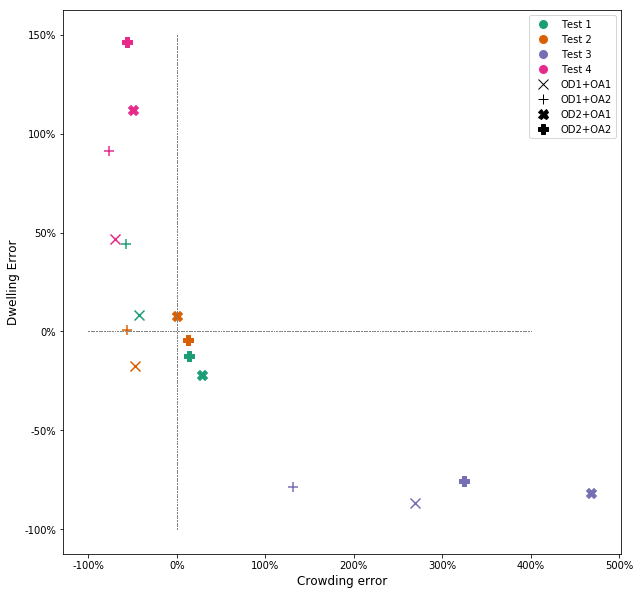

In [23]:
symbols = ["x", "+", "X", "P"]
# colours = ("blue", "orange", "grey", "green")
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_x = 'crowding_error'
plot_y = 'dwelling_error'

for t, test in enumerate(tests):
    test_scores = tests_scores.get(test)
    
    for m, model in enumerate(comb):
        scores = test_scores.get(model)
        x = scores.get(plot_x)
        y = scores.get(plot_y)
        
        axes.plot([0,0],[-1,1.5],'k-', linestyle = ":", lw=1, color = 'grey')
        axes.plot([-1,4],[0,0],'k-', linestyle = ":", lw=1, color = 'grey')
        
        #print('{}: {}: {} = {}, {} = {}'.format(test, model, plot_x, x, plot_y, y))
        
        axes.scatter(x, y, c=colours[t], marker=symbols[m], s=100)
        axes.set_xlabel('Crowding error', size='large')
        axes.set_ylabel('Dwelling Error', size='large')
        vals = axes.get_xticks()
        axes.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
        vals = axes.get_yticks()
        axes.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
        legend_elements = legend_elements + [Line2D([0],
                                                    [0],
                                                    marker=mark,
                                                    color='w', markeredgecolor='black',
                                                    label=mmap,markerfacecolor='black',
                                                    markersize=10) for mark, mmap in zip(symbols, comb)]
        
        axes.legend(handles=legend_elements)
        
plt.show()   


In [ ]:
fig.savefig('figures/3_4.png', bbox_inches='tight')

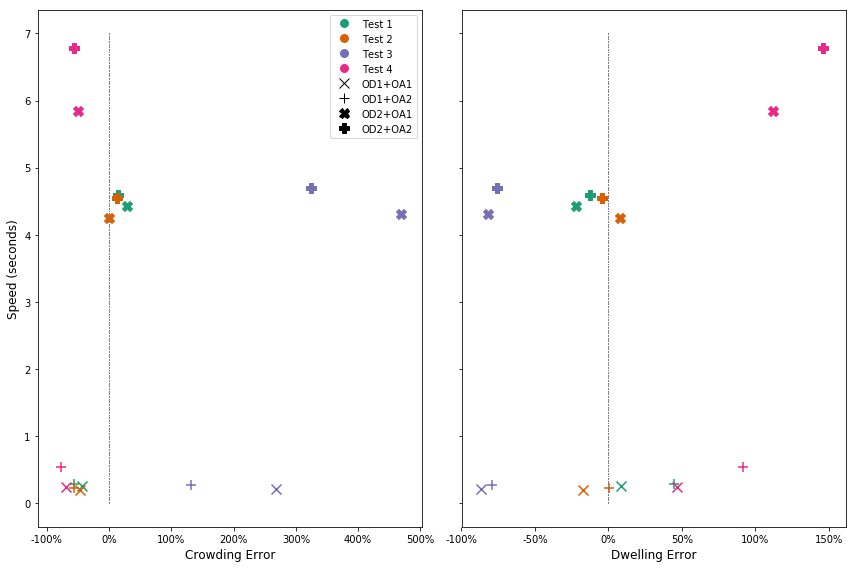

In [24]:
symbols = ["x", "+", "X", "P"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8), sharey=True)
plot_x = ['crowding_error', 'dwelling_error']
plot_x_short = ['Crowding Error', 'Dwelling Error']
plot_y = 'performance_seconds'

for t, test in enumerate(tests):
    test_scores = tests_scores.get(test)
    
    for m, model in enumerate(comb):
        scores = test_scores.get(model)
        
        for i, (item, item_short) in enumerate(zip(plot_x, plot_x_short)):
            x = scores.get(item)
            y = scores.get(plot_y)
            
            axes[i].plot([0,0],[0,7],'k-', linestyle = ":", lw=1, color = 'grey')

            #print('{}: {}: {} = {}, {} = {}'.format(test, model, plot_x, x, plot_y, y))

            axes[i].scatter(x, y, c=colours[t], marker=symbols[m], s=100)
            axes[i].set_xlabel(item_short, size='large')
            
            vals = axes[i].get_xticks()
            axes[i].set_xticklabels(['{:,.0%}'.format(x) for x in vals])

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
        legend_elements = legend_elements + [Line2D([0],
                                                    [0],
                                                    marker=mark,
                                                    color='w', markeredgecolor='black',
                                                    label=mmap,markerfacecolor='black',
                                                    markersize=10) for mark, mmap in zip(symbols, comb)]

        axes[0].legend(handles=legend_elements)
        axes[0].set_ylabel('Speed (seconds)', size='large')

fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)
plt.show()   

In [ ]:
fig.savefig('figures/3_5.png', bbox_inches='tight')

## 4. Calculate Tracking Attributes
Calculate pedestrian attributes such as accumulated distance, dwelling time and direction.

In [25]:
realtime_results, _ = tracker.get_analysis(gts['test1'], 0, 0)
unique_ids_array = tracker.get_ID_aggregation(realtime_results)
trajectory_dict = tracker.get_trajectory_dict(unique_ids_array, realtime_results)

durations = unique_ids_array[:,8]
distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

headers = ['frame',
           'ID',
           'left',
           'top',
           'width',
           'height',
           'conf',
           'trajectory',
           'duration',
           'x',
           'y',
           'dx',
           'dy',
           'dx_acc',
           'dy_acc',
           'distance',
           'distance_acc',
           'direction',
           'x_av',
           'y_av',
           'direction_av',
          'year',
          'month',
          'day']
    
print(len(durations))
print(len(distances))
pd.DataFrame(unique_ids_array, columns = headers)

Created results analysis array with shape: (42, 24)
Created unique ids array with shape: (14, 24)
Created unique trajectories dict of length 14
14
6


frame    ID        left         top       width      height      conf  \
0   14894.0  14.0  706.038265    0.241492   51.372986  123.699393  0.983675   
1   14891.0  12.0  756.605301   29.870653  136.842041  374.914470  0.995801   
2   14881.0  13.0  437.659836    2.462207   26.294518   54.551525  0.979821   
3   14852.0  11.0  774.308109    0.000000   86.384010  148.336528  0.939808   
4   14851.0  10.0  394.912119    2.447428   20.721703   47.414357  0.887699   
5   14850.0   9.0  397.531099    0.774531   48.712864   55.573995  0.890794   
6   14843.0   8.0    0.000000  157.445776  174.730225  382.554223  0.883588   
7   14841.0   6.0  396.613998    0.000000   17.611427   35.599038  0.925260   
8   14840.0   7.0  535.006828    4.706347   65.623169  124.767527  0.954244   
9   14840.0   5.0   88.276033  171.129565  435.254660  363.371660  0.975803   
10  14818.0   4.0  378.122835    1.736228   21.135235   49.547179  0.805538   
11  14818.0   1.0  429.525232    0.314464   28.704128   46.591856  0.901146   
12  14817.0   2.0  518.612080    0.370646   67.697868  124.933724  0.662038   
13  14809.0   0.0  633.252125    0.000000   29.149246   38.528638  0.574003   

    trajectory  duration           x ...       dy_acc    distance  \
0          1.0      14.0  731.724758 ...  -248.177308   74.943882   
1          1.0      12.0  825.026321 ...   152.876949    7.201242   
2          0.0       1.0  450.807095 ...     0.000000    0.000000   
3          0.0       1.0  817.500114 ...     0.000000    0.000000   
4          0.0       1.0  405.272970 ...     0.000000    0.000000   
5          1.0       3.0  421.887531 ...  -153.508646  195.229585   
6          0.0       1.0   87.365112 ...     0.000000    0.000000   
7          1.0       2.0  405.419712 ...   -54.423904  147.105309   
8          0.0       1.0  567.818413 ...     0.000000    0.000000   
9          0.0       1.0  305.903363 ...     0.000000    0.000000   
10         0.0       1.0  388.690453 ...     0.000000    0.000000   
11         1.0       2.0  443.877296 ...   -47.962538   48.123053   
12         0.0       1.0  552.461014 ...     0.000000    0.000000   
13         1.0       2.0  647.826748 ...   -25.811650   52.262461   

    distance_acc  direction        x_av        y_av  direction_av  year  \
0     411.784580  -2.871076   52.266054    4.435085     -1.796814   0.0   
1     470.978546   1.992015   68.752193   18.110657      0.415182   0.0   
2       0.000000   0.000000  450.807095   29.737970      0.000000   0.0   
3       0.000000   0.000000  817.500114   74.168264      0.000000   0.0   
4       0.000000   0.000000  405.272970   26.154607      0.000000   0.0   
5     681.509989  -2.876110  140.629177    9.520509     -0.491139   0.0   
6       0.000000   0.000000   87.365112  348.722888      0.000000   0.0   
7     147.105309  -2.762621  202.709856    8.899760     -2.762621   0.0   
8       0.000000   0.000000  567.818413   67.090111      0.000000   0.0   
9       0.000000   0.000000  305.903363  352.815395      0.000000   0.0   
10      0.000000   0.000000  388.690453   26.509818      0.000000   0.0   
11     48.123053  -1.652495  221.938648   11.805196     -1.652495   0.0   
12      0.000000   0.000000  552.461014   62.837508      0.000000   0.0   
13     52.262461  -0.516552  323.913374    9.632160     -0.516552   0.0   

    month  day  
0     0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
5     0.0  0.0  
6     0.0  0.0  
7     0.0  0.0  
8     0.0  0.0  
9     0.0  0.0  
10    0.0  0.0  
11    0.0  0.0  
12    0.0  0.0  
13    0.0  0.0  

[14 rows x 24 columns]

## 5. Pedestrian Behaviours
Calculate and plot individual aggregated dwell time (number of frames tracked at location) and distances (pixel distance travelled in frame).

Created results analysis array with shape: (1172, 24)
Created unique ids array with shape: (342, 24)
Created results analysis array with shape: (486, 24)
Created unique ids array with shape: (16, 24)
Created results analysis array with shape: (91, 24)
Created unique ids array with shape: (32, 24)
Created results analysis array with shape: (42, 24)
Created unique ids array with shape: (14, 24)
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (103, 24)
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (79, 24)
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (172, 24)
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (148, 24)
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (59, 24)
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (37, 24)
Creat

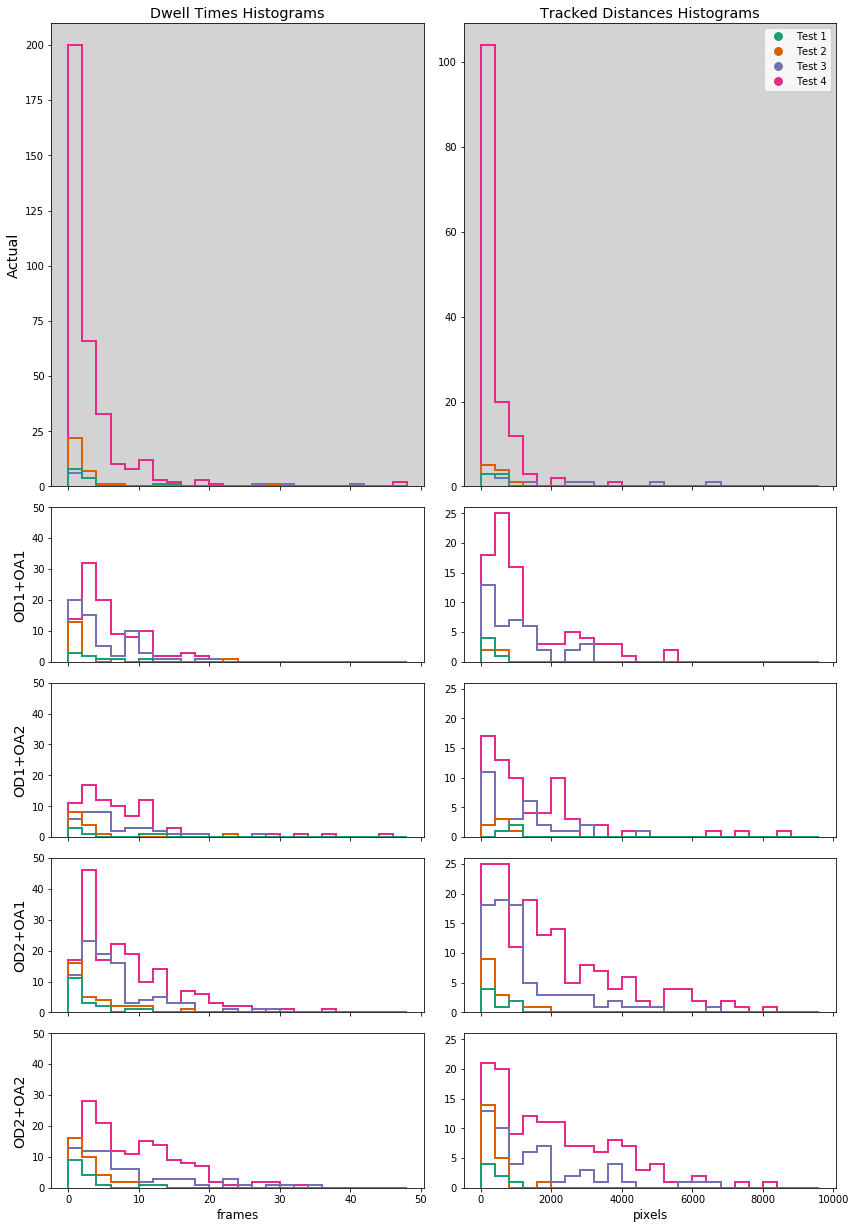

In [26]:
# Histogram for unique individuals
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,17), sharex='col', gridspec_kw = {'height_ratios':[3,1,1,1,1]})

plots = ['Dwell Times Histograms', 'Tracked Distances Histograms']

for t, test in enumerate(reversed(tests)):
    gt_results = gts.get(test)

    realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
    unique_ids_array = tracker.get_ID_aggregation(realtime_results)
    #trajectory_dict = get_trajectory_dict(unique_ids_array, realtime_results)

    durations = unique_ids_array[:,8]
    distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

    axes[0,0].hist(durations, alpha=1, color = colours_r[t], bins=list(np.arange(0,50,2)), histtype='step', lw=2)
    axes[0,1].hist(distances, alpha=1, color = colours_r[t], bins=list(range(0,10000,400)), histtype='step', lw=2)
    
    axes[0,0].set_ylabel('Actual', size='x-large')
    
    axes[0,0].set_facecolor('lightgrey')
    axes[0,1].set_facecolor('lightgrey') 

for t, test in enumerate(reversed(tests)):
    test_results = tests_results.get(test)
    
    for row, model in enumerate(comb):
        results = test_results.get(model)
        
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_ids_array = tracker.get_ID_aggregation(realtime_results)
        #trajectory_dict = get_trajectory_dict(unique_ids_array, realtime_results)
        
        durations = unique_ids_array[:,8]
        distances = unique_ids_array[unique_ids_array[:,7] == 1][:,16]

        axes[row + 1,0].hist(durations, alpha=1, color = colours_r[t], bins=list(np.arange(0,50,2)), histtype='step', lw=2)
        axes[row + 1,1].hist(distances, alpha=1, color = colours_r[t], bins=list(range(0,10000,400)), histtype='step', lw=2)
        
        axes[row + 1,0].set_ylim(0, 50)
#         axes[row + 1,0].set_xlim(0, 12)
        axes[row + 1,1].set_ylim(0, 26)
#         axes[row + 1,1].set_xlim(0, 2000)
        
        axes[row + 1,0].set_ylabel(comb[row], size='x-large')

legend_elements = [Line2D([0], [0], marker='o', color='w', label=cmap,
                          markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]
axes[0,1].legend(handles=legend_elements)
axes[4,0].set_xlabel('frames', size='large')
axes[4,1].set_xlabel('pixels', size='large')
        
pad = 5
for ax, text in zip(axes[0], plots):
    ax.annotate(text, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)
plt.show() 

In [ ]:
fig.savefig('figures/3_10.png', bbox_inches='tight')

## 6. Process Temporal Patterns
Calculate crowding, dwelling and distance travelled over time

In [27]:
# Create timeline results for 

timeline_tests_results = {}

for t, test in enumerate(tests):
    test_results = tests_results.get(test)
    
    gt_results = gts.get(test)
    realtime_actual, _ = tracker.get_analysis(gt_results, 0, 0)
    
    gt_timeline_crowding = {}
    gt_timeline_dwelling = {}
    gt_timeline_distance = {}
        
    min_frame_counter = int(min(gt_results[:,0]))
    #frame_counter_max = max(max(results[:,0]), max(gt_results[:,0]))
    frame_counter = min_frame_counter
    frame_counter_max = frame_counter + 99
    
    timeline_models_results = {}
    
    while True:
        crowding_counter = 0
        dwelling_counter = 0
        distance_counter = 0
        for result in realtime_actual:
            if result[0] == frame_counter:
                crowding_counter += 1
                dwelling_counter += result[8]
                distance_counter += result[16]

        gt_timeline_crowding[frame_counter] = crowding_counter
        gt_timeline_dwelling[frame_counter] = dwelling_counter
        gt_timeline_distance[frame_counter] = distance_counter

        if frame_counter == frame_counter_max:
            break
        frame_counter += 1
            
    gt_timeline_results = {'Crowding': gt_timeline_crowding, 'Dwelling': gt_timeline_dwelling, 'Distance': gt_timeline_distance}
    timeline_models_results['Actual'] = gt_timeline_results
    
    for row, model in enumerate(comb):
           
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        
        timeline_crowding = {}
        timeline_dwelling = {}
        timeline_distance = {}
        
        frame_counter = min_frame_counter
        
        while True:
            crowding_counter = 0
            dwelling_counter = 0
            distance_counter = 0
            for result in realtime_results:
                if result[0] == frame_counter:
                    crowding_counter += 1
                    dwelling_counter += result[8]
                    distance_counter += result[16]
                    
            timeline_crowding[frame_counter] = crowding_counter
            timeline_dwelling[frame_counter] = dwelling_counter
            timeline_distance[frame_counter] = distance_counter
            
            if frame_counter == frame_counter_max:
                break
            frame_counter += 1
            
        model_timeline_results = {'Crowding': timeline_crowding, 'Dwelling': timeline_dwelling, 'Distance': timeline_distance}
        timeline_models_results[model] = model_timeline_results
        
    timeline_tests_results[test] = timeline_models_results   
        

Created results analysis array with shape: (42, 24)
Created results analysis array with shape: (26, 24)
Created results analysis array with shape: (26, 24)
Created results analysis array with shape: (42, 24)
Created results analysis array with shape: (42, 24)
Created results analysis array with shape: (91, 24)
Created results analysis array with shape: (40, 24)
Created results analysis array with shape: (40, 24)
Created results analysis array with shape: (98, 24)
Created results analysis array with shape: (98, 24)
Created results analysis array with shape: (486, 24)
Created results analysis array with shape: (237, 24)
Created results analysis array with shape: (237, 24)
Created results analysis array with shape: (499, 24)
Created results analysis array with shape: (499, 24)
Created results analysis array with shape: (1172, 24)
Created results analysis array with shape: (518, 24)
Created results analysis array with shape: (518, 24)
Created results analysis array with shape: (1249, 24)
C

## 7. Plot Temporal Patterns

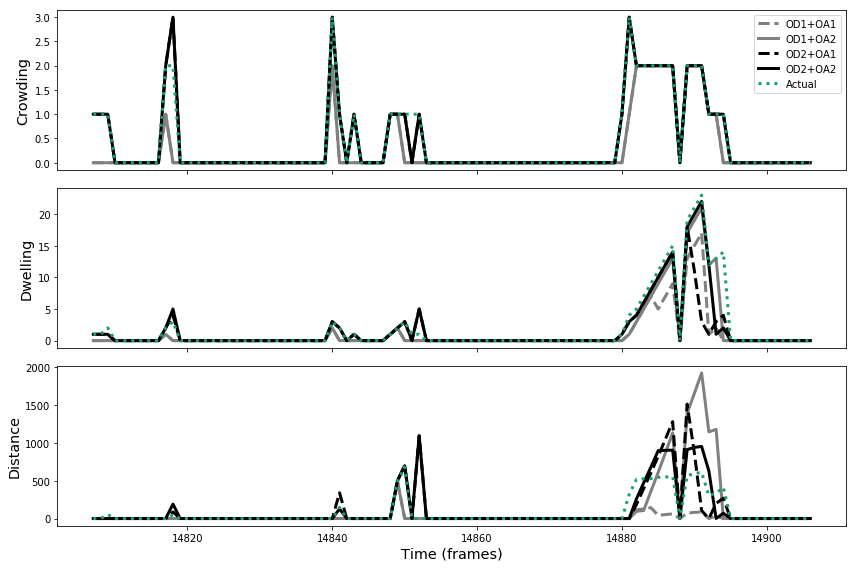

In [28]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#1b9e77']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test1'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model, linewidth=3)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()

fig.tight_layout()
plt.show()


In [ ]:
fig.savefig('figures/3_6test1.png', bbox_inches='tight')

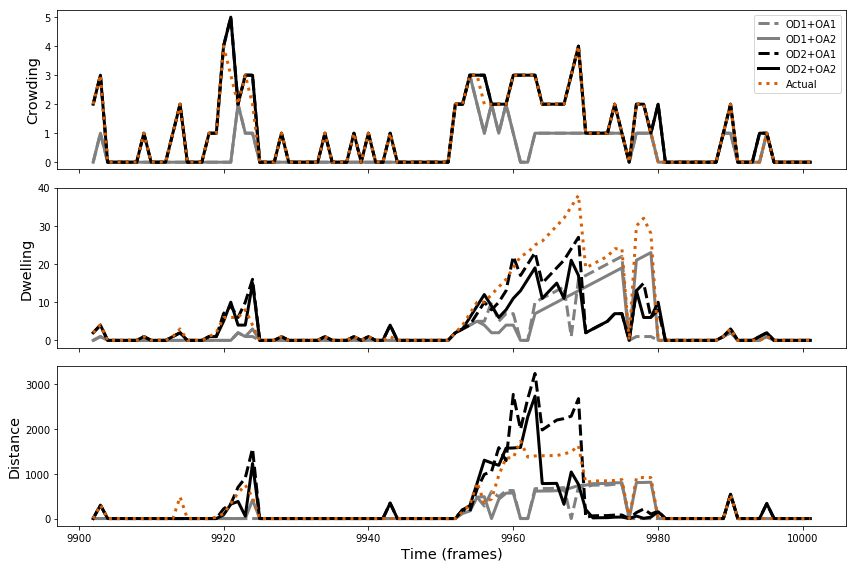

In [29]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#d95f02']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test2'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model, linewidth=3)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('figures/3_6test2.png', bbox_inches='tight')

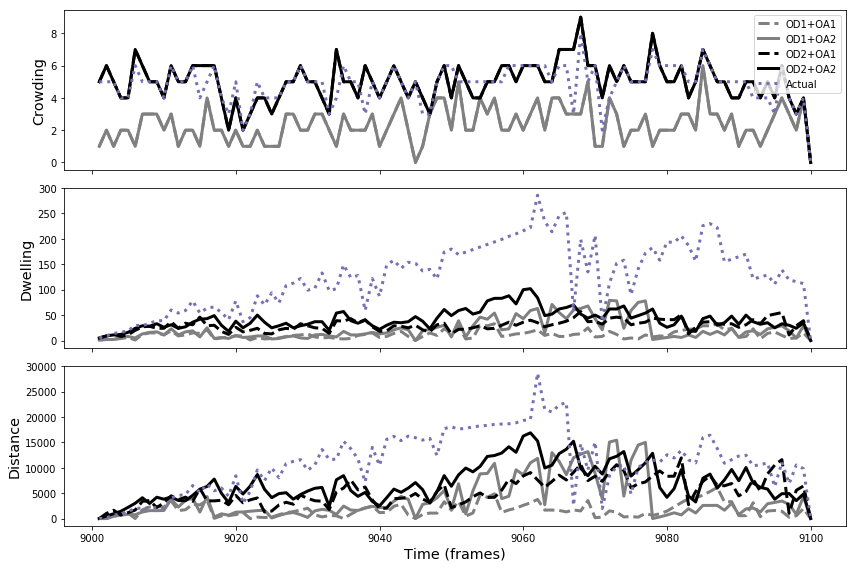

In [30]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#7570b3']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test3'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model, linewidth=3)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('figures/3_6test3.png', bbox_inches='tight')

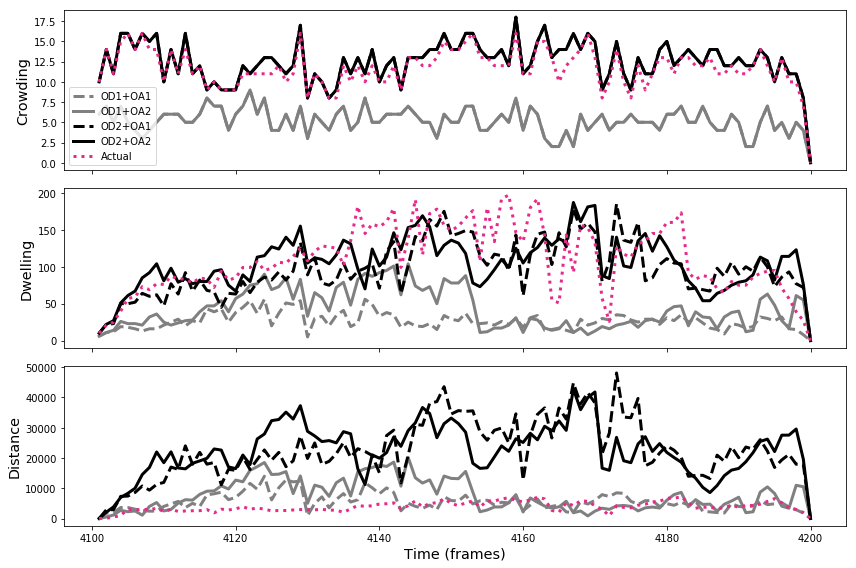

In [31]:
# Plot timeline results
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,8), sharex=True)

rows = ['Crowding', 'Dwelling', 'Distance']
plots = comb + ['Actual']
linestyles = ['--', '-', '--', '-', ':']
linecolours = ['grey', 'grey', 'black', 'black', '#e7298a']

for row, query in enumerate(rows):
    for plotter, model in enumerate(plots):
        data = timeline_tests_results['test4'][model][query]
        x = list(data.keys())
        y = list(data.values())
        axes[row].plot(x, y, linestyle=linestyles[plotter], color=linecolours[plotter], label=model, linewidth=3)
        axes[row].set_ylabel(query, size='x-large')
        axes[2].set_xlabel('Time (frames)', size='x-large')

        axes[0].legend()
        
fig.tight_layout()
plt.show()

In [ ]:
fig.savefig('figures/3_6test4.png', bbox_inches='tight')

## 8. Visualise Trajectories
Calculate and plot trajectories.

Created results analysis array with shape: (1172, 24)
Created unique ids array with shape: (342, 24)
Created unique trajectories dict of length 342
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (103, 24)
Created unique trajectories dict of length 103
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (79, 24)
Created unique trajectories dict of length 79
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (172, 24)
Created unique trajectories dict of length 172
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (148, 24)
Created unique trajectories dict of length 148
Created results analysis array with shape: (486, 24)
Created unique ids array with shape: (16, 24)
Created unique trajectories dict of length 16
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (59, 24)
Created unique traje

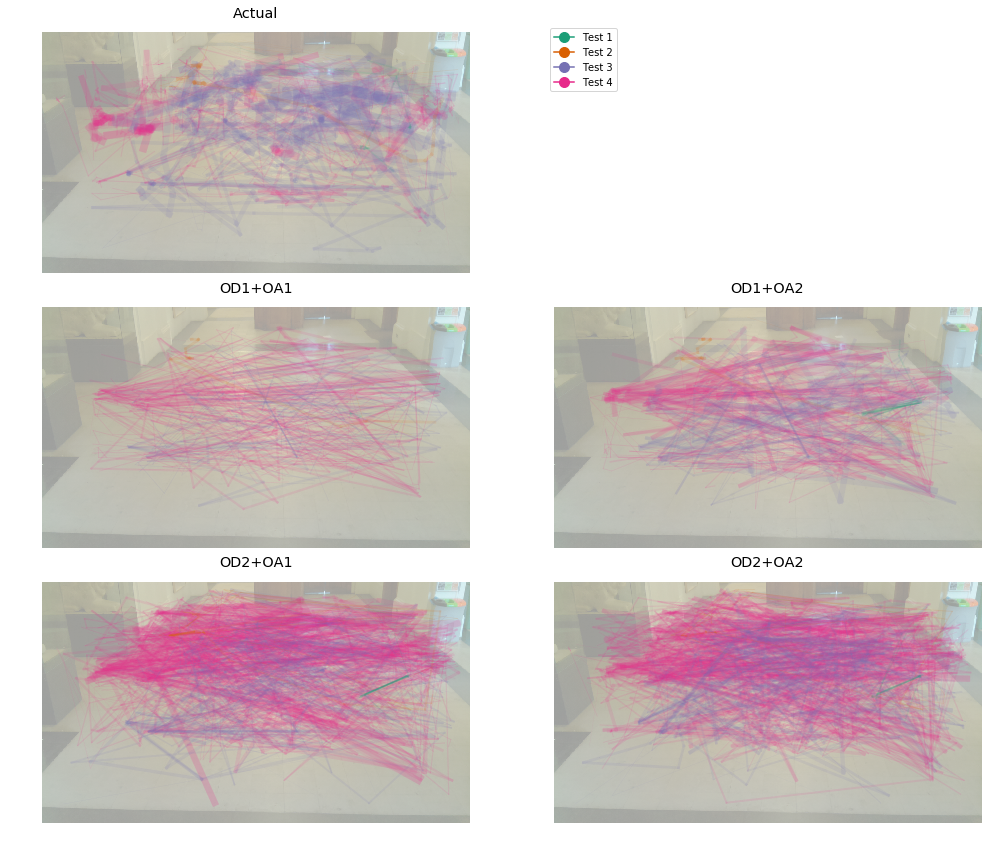

In [32]:
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 100

titles = ['Trajectories']

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(14, 12))
axes[0,0].imshow(frame)
for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        axes[row+1,col].imshow(frame)

for t, test in enumerate(tests_r):
    test_results = tests_results.get(test)
    gt_results = gts.get(test)
    gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
    gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
    gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
    

    for unique in gt_unique_detections:
        ID = unique[1]
        duration = unique[8]
        trajectory_x, trajectory_y = gt_trajectory_dict.get(ID)
        for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
            axes[0,0].plot([x1,x2], [y1,y2], alpha=0.1, c=colours_r[t], linewidth=duration/8, label='actual')
            axes[0,0].set_title('Actual', size='x-large')
            axes[0,0].axis('off')
            axes[0,1].axis('off')
    
    for row, odm in enumerate(odms):
        for col, oam in enumerate(oams):
            model = odm + '+' + oam
            results = test_results.get(model)
            realtime_results, _ = tracker.get_analysis(results, 0, 0)
            unique_detections = tracker.get_ID_aggregation(realtime_results)
            trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)

            for unique in unique_detections:
                ID = unique[1]
                duration = unique[8]
                trajectory_x, trajectory_y = trajectory_dict.get(ID)
                for x1, y1, x2, y2 in zip(trajectory_x[1:], trajectory_y[1:], trajectory_x[:-1], trajectory_y[:-1]):
                    axes[row+1,col].plot([x1,x2], [y1,y2], alpha=0.1, c=colours_r[t], linewidth=duration/8, label=test)
                    axes[row+1, col].set_title(model, size='x-large')
                    axes[row+1, col].axis('off')

    legend_elements = [Line2D([0], [0], marker='o', color=c, label=cmap,
                              markerfacecolor=c, markersize=10) for c, cmap in zip(colours, tests_short)]

    axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.15, hspace=0.06)

plt.show()

In [ ]:
fig.savefig('figures/3_20.png', bbox_inches='tight')

## 9. Visualise Flows
Calculat and plot flow vectors using a spatial grid for aggregation.

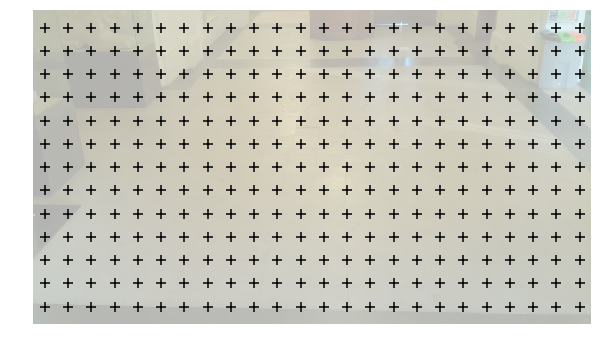

In [7]:
frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, 40)
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, sharex=True, figsize=(10, 6))
axes.imshow(frame)
for point in grid:  
    axes.scatter(point[0], point[1], c='black', marker='+', s=100)
    axes.axis('off')

In [ ]:
fig.savefig('figures/3_20grid.png', bbox_inches='tight')

Created results analysis array with shape: (1172, 24)
Created unique ids array with shape: (342, 24)
Created unique trajectories dict of length 342
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (103, 24)
Created unique trajectories dict of length 103
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (79, 24)
Created unique trajectories dict of length 79
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (172, 24)
Created unique trajectories dict of length 172
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (148, 24)
Created unique trajectories dict of length 148
Created results analysis array with shape: (486, 24)
Created unique ids array with shape: (16, 24)
Created unique trajectories dict of length 16
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (59, 24)
Created unique traje

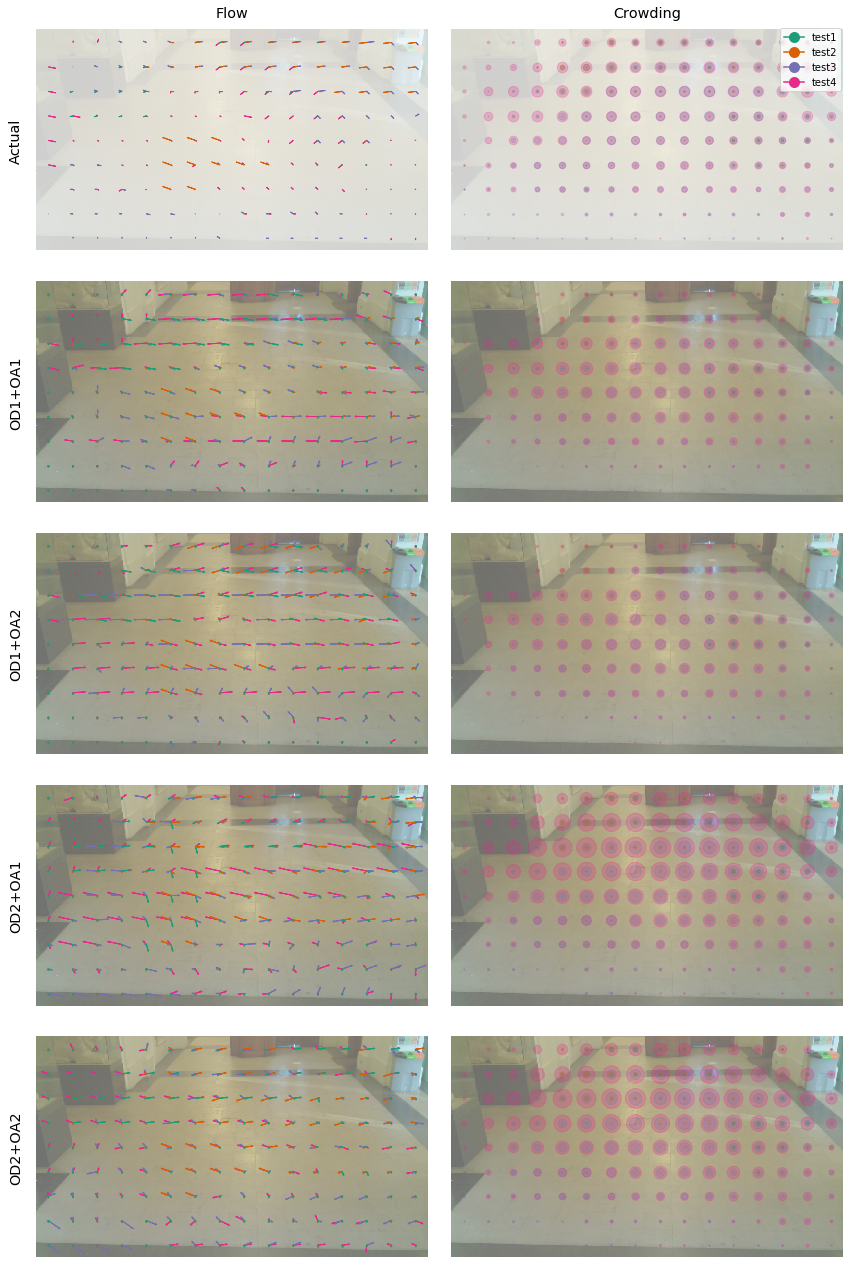

In [33]:
step_size = 60
max_kernel_size = 75
correction = 25

comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 50

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=5, ncols=2, sharey=True, sharex=True, figsize=(12, 18))

axes[0,0].imshow(frame)
axes[0,1].imshow(frame)

for t, test in enumerate(tests_r[:]):
    test_results = tests_results.get(test)
    
    gt_results = gts.get(test)
    gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
    gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
    gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
    g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                              max_kernel_size,
                                                              gt_unique_detections,
                                                              gt_trajectory_dict)
    
    
    for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):
        
        axes[0,0].arrow(point[0], point[1],
                        p_dx/correction,
                        -p_dy/correction,
                        edgecolor=colours_r[t])
        
        axes[0,1].scatter(point[0], point[1],
                          s=p_trajectory,
                          c=colours_r[t],
                          alpha=.25,
                          label = tests_r[t])
        
        axes[0,0].set_title('Flow', size='x-large')
        axes[0,1].set_title('Crowding', size='x-large')
        axes[0,0].axis('off')
        axes[0,1].axis('off')
        
    for row, model in enumerate(comb):
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_detections = tracker.get_ID_aggregation(realtime_results)
        trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,0].imshow(frame)
        axes[row+1,1].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):
            
            axes[row+1,0].arrow(point[0], point[1],
                                  p_dx/correction,
                                  -p_dy/correction,
                                  edgecolor=colours_r[t],
                                 head_width=3)
            
            axes[row+1,1].scatter(point[0], point[1],
                                    s=p_trajectory,
                                    c=colours_r[t],
                                    alpha=.25,
                                    label = tests_r[t])

            axes[row+1,0].axis('off')
            axes[row+1,1].axis('off')

legend_elements = [Line2D([0],
                          [0],
                          marker='o',
                          color=c,
                          label=cmap,
                          markerfacecolor=c,
                          markersize=10) for c, cmap in zip(colours, tests)]

pad = 10
rows = ['Actual'] + comb
for ax, r in zip(axes[:,0], rows):
    ax.annotate(r, xy=(0, 0.5), xytext=(- pad, 0),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='right', va='center', rotation = 90)

axes[0,1].legend(handles=legend_elements, loc=1)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [ ]:
fig.savefig('figures/3_7.png', bbox_inches='tight')

Created results analysis array with shape: (42, 24)
Created unique ids array with shape: (14, 24)
Created unique trajectories dict of length 14
Created results analysis array with shape: (26, 24)
Created unique ids array with shape: (8, 24)
Created unique trajectories dict of length 8
Created results analysis array with shape: (26, 24)
Created unique ids array with shape: (6, 24)
Created unique trajectories dict of length 6
Created results analysis array with shape: (42, 24)
Created unique ids array with shape: (18, 24)
Created unique trajectories dict of length 18
Created results analysis array with shape: (42, 24)
Created unique ids array with shape: (16, 24)
Created unique trajectories dict of length 16


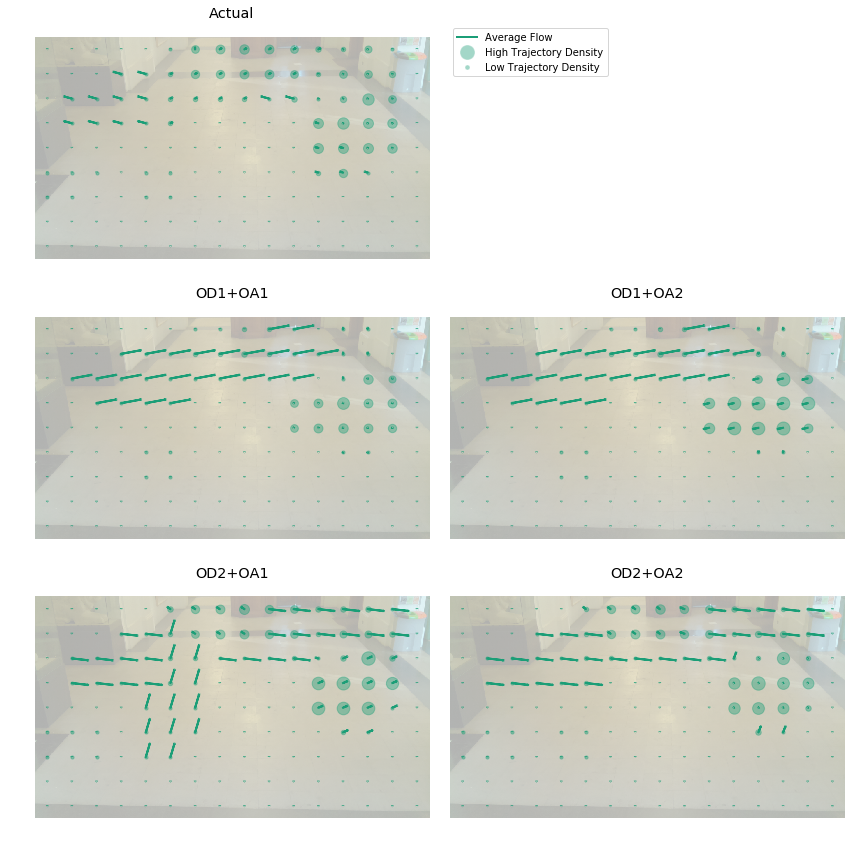

In [34]:
step_size = 60
max_kernel_size = 75
correction = 10

t = 0
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 12))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t],
                    linewidth=2)

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*10,
                      c=colours[t],
                      alpha=.4,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_detections = tracker.get_ID_aggregation(realtime_results)
        trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t],
                                  linewidth=2)

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*10,
                                    c=colours[t],
                                    alpha=.4,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [ ]:
fig.savefig('figures/3_21test1.png', bbox_inches='tight')

Created results analysis array with shape: (91, 24)
Created unique ids array with shape: (32, 24)
Created unique trajectories dict of length 32
Created results analysis array with shape: (40, 24)
Created unique ids array with shape: (17, 24)
Created unique trajectories dict of length 17
Created results analysis array with shape: (40, 24)
Created unique ids array with shape: (14, 24)
Created unique trajectories dict of length 14
Created results analysis array with shape: (98, 24)
Created unique ids array with shape: (32, 24)
Created unique trajectories dict of length 32
Created results analysis array with shape: (98, 24)
Created unique ids array with shape: (36, 24)
Created unique trajectories dict of length 36


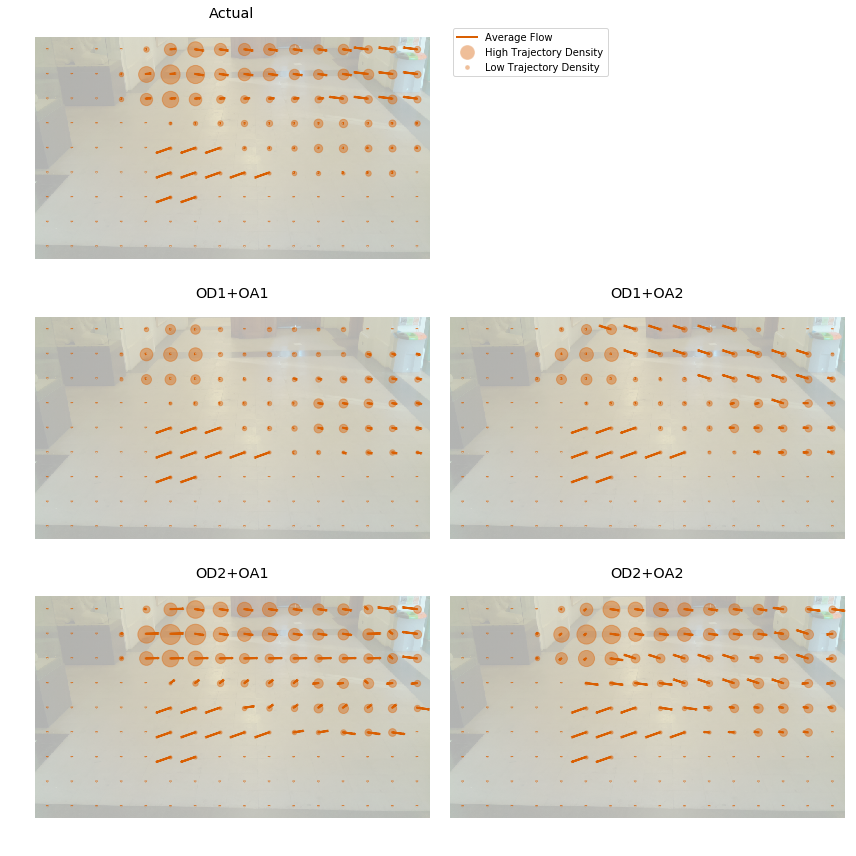

In [35]:
step_size = 60
max_kernel_size = 75
correction = 15

t = 1
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 12))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t],
                   linewidth=2)

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*10,
                      c=colours[t],
                      alpha=.4,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_detections = tracker.get_ID_aggregation(realtime_results)
        trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t],
                                 linewidth=2)

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*10,
                                    c=colours[t],
                                    alpha=.4,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [ ]:
fig.savefig('figures/3_21test2.png', bbox_inches='tight')

Created results analysis array with shape: (486, 24)
Created unique ids array with shape: (16, 24)
Created unique trajectories dict of length 16
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (59, 24)
Created unique trajectories dict of length 59
Created results analysis array with shape: (237, 24)
Created unique ids array with shape: (37, 24)
Created unique trajectories dict of length 37
Created results analysis array with shape: (499, 24)
Created unique ids array with shape: (91, 24)
Created unique trajectories dict of length 91
Created results analysis array with shape: (499, 24)
Created unique ids array with shape: (68, 24)
Created unique trajectories dict of length 68


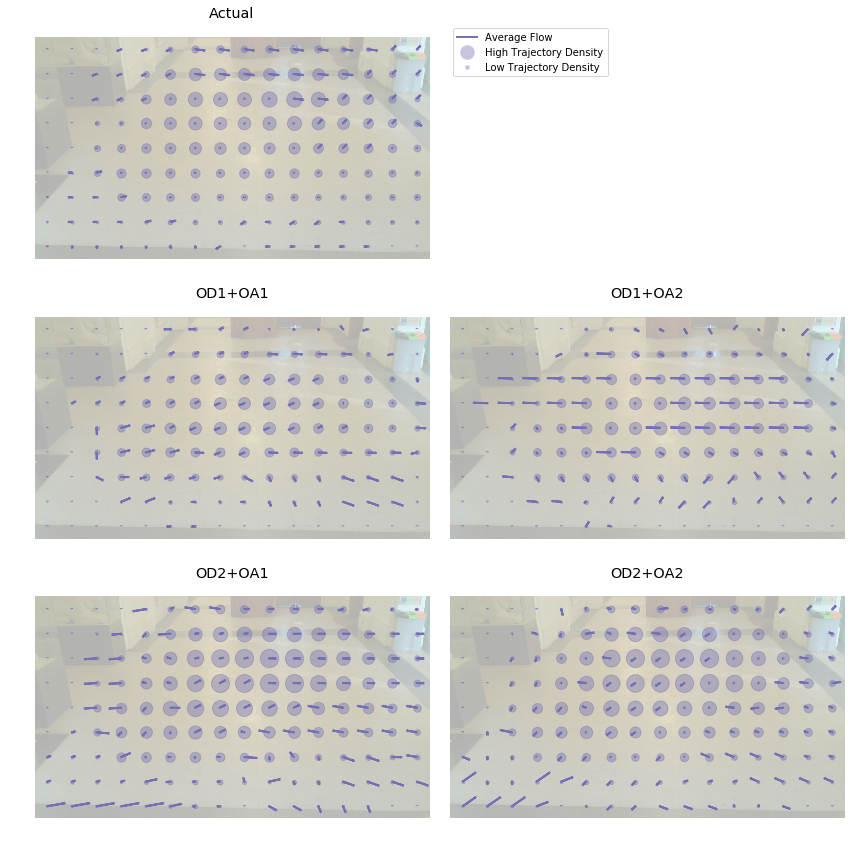

In [36]:
step_size = 60
max_kernel_size = 75
correction = 20

t = 2
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 12))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t],
                   linewidth=2)

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory*2,
                      c=colours[t],
                      alpha=.4,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_detections = tracker.get_ID_aggregation(realtime_results)
        trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t],
                                 linewidth=2)

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory*2,
                                    c=colours[t],
                                    alpha=.4,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [ ]:
fig.savefig('figures/3_21test3.png', bbox_inches='tight')

Created results analysis array with shape: (1172, 24)
Created unique ids array with shape: (342, 24)
Created unique trajectories dict of length 342
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (103, 24)
Created unique trajectories dict of length 103
Created results analysis array with shape: (518, 24)
Created unique ids array with shape: (79, 24)
Created unique trajectories dict of length 79
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (172, 24)
Created unique trajectories dict of length 172
Created results analysis array with shape: (1249, 24)
Created unique ids array with shape: (148, 24)
Created unique trajectories dict of length 148


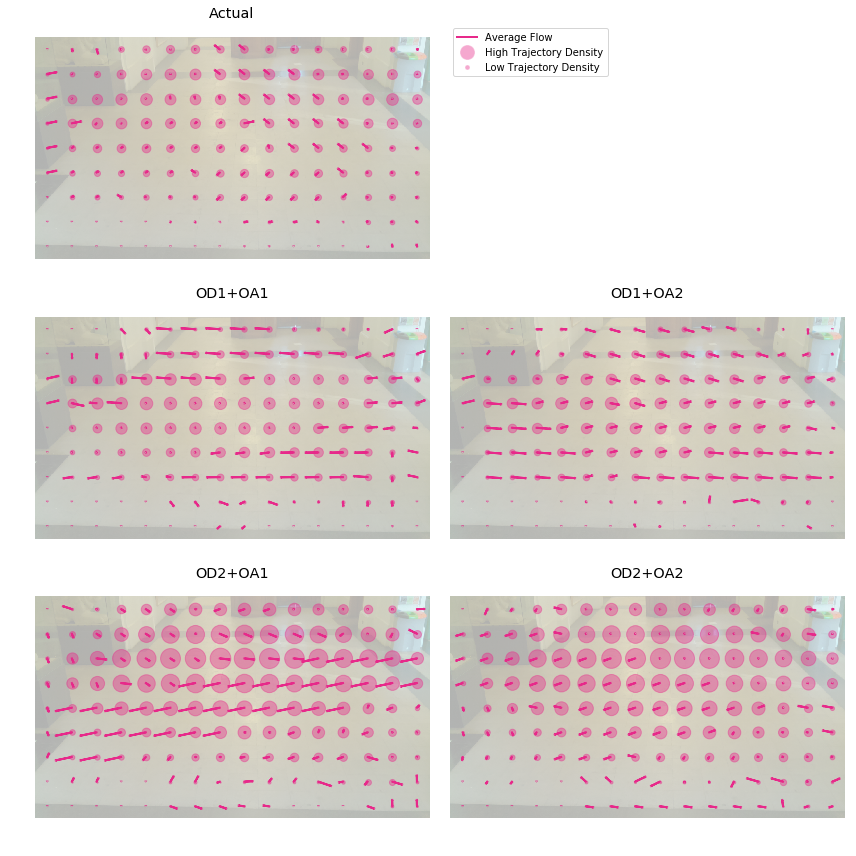

In [37]:
step_size = 60
max_kernel_size = 75
correction = 20

t = 3
test = tests[t]


comb = ['OD1+OA1', 'OD1+OA2', 'OD2+OA1', 'OD2+OA2']
colours = ('#1b9e77', '#d95f02', '#7570b3', '#e7298a')
colours_r = ('#e7298a', '#7570b3', '#d95f02', '#1b9e77')
tests_r = ['test4', 'test3', 'test2', 'test1']

frame = cv2.imread(os.path.join('test_inputs', 'test0', '01-03-2015', 'timelapse_05600.jpg'))
h, w = frame.shape[:2]
frame = cv2.resize(frame, (int(w/2), int(h/2)))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
frame[:,:,3] = 80

grid = tracker.create_grid(frame, step_size)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(12, 12))


test_results = tests_results.get(test)

gt_results = gts.get(test)
gt_realtime_results, _ = tracker.get_analysis(gt_results, 0, 0)
gt_unique_detections = tracker.get_ID_aggregation(gt_realtime_results)
gt_trajectory_dict = tracker.get_trajectory_dict(gt_unique_detections, gt_realtime_results)
g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                          max_kernel_size,
                                                          gt_unique_detections,
                                                          gt_trajectory_dict)

axes[0,0].imshow(frame)

for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

    axes[0,0].arrow(point[0], point[1],
                    p_dx/correction,
                    p_dy/correction,
                    edgecolor=colours[t],
                   linewidth=2)

    axes[0,0].scatter(point[0], point[1],
                      s=p_trajectory,
                      c=colours[t],
                      alpha=.4,
                      label = tests_r[t])

    axes[0,0].set_title('Actual', size='x-large')
    axes[0,0].axis('off')
    axes[0,1].axis('off')

for row, odm in enumerate(odms):
    for col, oam in enumerate(oams):
        model = odm + '+' + oam
        
        results = test_results.get(model)
        realtime_results, _ = tracker.get_analysis(results, 0, 0)
        unique_detections = tracker.get_ID_aggregation(realtime_results)
        trajectory_dict = tracker.get_trajectory_dict(unique_detections, realtime_results)
        g_trajectory, g_distance, g_dx, g_dy = tracker.get_kernel_results(grid,
                                                                  max_kernel_size,
                                                                  unique_detections,
                                                                  trajectory_dict)

        axes[row+1,col].imshow(frame)

        for point, p_trajectory, p_duration, p_dx, p_dy in zip(grid, g_trajectory, g_distance, g_dx, g_dy):

            axes[row+1,col].arrow(point[0], point[1],
                                  p_dx/correction,
                                  p_dy/correction,
                                  edgecolor=colours[t],
                                 linewidth=2)

            axes[row+1,col].scatter(point[0], point[1],
                                    s=p_trajectory,
                                    c=colours[t],
                                    alpha=.4,
                                    label = tests[t])

            axes[row+1,col].axis('off')
            axes[row+1,col].axis('off')
            axes[row+1, col].set_title(model, size='x-large')

legend_elements = [Line2D([0], [0], color=colours[t], lw=2, label='Average Flow'),
                   Line2D([0], [0], marker='o', color='w', label='High Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Low Trajectory Density',
                          markerfacecolor=colours[t], alpha = 0.4, markersize=5),]

pad = 10
rows = ['Actual'] + comb

axes[0,1].legend(handles=legend_elements, loc=2)
    
fig.tight_layout()
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.06)

plt.show()    
         

In [ ]:
fig.savefig('figures/3_21test4.png', bbox_inches='tight')